# Extracting data from MISP using PyMISP

## Recovering the API KEY

- Go to `Global Actions` then `My Profile`
- Access the `/users/view/me` URL

In [2]:
from pymisp import PyMISP
import urllib3
urllib3.disable_warnings()

misp_url = 'https://training.misp-community.org/'
misp_key = 'YOURAPIKEY'
# Should PyMISP verify the MISP certificate
misp_verifycert = False

misp = PyMISP(misp_url, misp_key, misp_verifycert)

In [3]:
import datetime
from pprint import pprint
import base64
import subprocess

## Retrieving an Event

In [4]:
r1 = misp.get_event('9802116c-3ec3-4a8e-8b39-5c69b08df5ab', pythonify=True)
print(r1)
r2 = misp.get_event(60, pythonify=False)
print(type(r2))
print(r2['Event']['info'])

<MISPEvent(info=OSINT - Zero-Day Exploitation of Unauthenticated Remote Code Execution Vulnerability in GlobalProtect (CVE-2024-3400))
<class 'dict'>
OSINT - Zero-Day Exploitation of Unauthenticated Remote Code Execution Vulnerability in GlobalProtect (CVE-2024-3400)


## Searching the Event index

In [4]:
r = misp.search_index(pythonify=True)
print(r[1].uuid)

339b8437-13e8-4ae6-97dc-47cf909aa78d


#### Only published Events

In [5]:
r = misp.search_index(published=True, pythonify=True)
print(r)
# print(r[0].to_dict())

[<MISPEvent(info=Targeted phishing - PDF documents / phishkit), <MISPEvent(info=Test Pull From Docker), <MISPEvent(info=OSINT - Zero-Day Exploitation of Unauthenticated Remote Code Execution Vulnerability in GlobalProtect (CVE-2024-3400)), <MISPEvent(info=OSINT - ConnectWise ScreenConnect attacks deliver malware)]


#### Playing with time

**Multiple type of timestamps for Events**
- `timestamp`: Timestamp of the **last modification** of the Event or its content (include Attributes, Objects, Tags, ...)
- `published_timestamp`: Timestamp of the **last publication** of the Event
- To generate report, you usually want to use `publish_timestamp`

**Multiple type of dates for Events**
- `date_from`: Only events having a more recent date will be returned
- `date_to`: Only events having an older date will be returned
- Both can be used at once to specify a time window


In [6]:
# Using string literal
sinceLastMonth = '30d'
# Using Python's datetime
sinceLastMonth = datetime.date.today() - datetime.timedelta(days=30)

r = misp.search_index(published=True, publish_timestamp=sinceLastMonth, pythonify=True)
pprint(r)

[<MISPEvent(info=Targeted phishing - PDF documents / phishkit),
 <MISPEvent(info=Test Pull From Docker),
 <MISPEvent(info=OSINT - Zero-Day Exploitation of Unauthenticated Remote Code Execution Vulnerability in GlobalProtect (CVE-2024-3400)),
 <MISPEvent(info=OSINT - ConnectWise ScreenConnect attacks deliver malware)]


#### Data returned
- Searching the index will only returns high-level information about the Event and its attached context

- Can be useful for:
    - Statistics about number of created Event
    - Statistics about Organisation creating Event over time
    - Statistics about distribution level usage
- And, **If Event correctly contextualized**
    - Statistics about **type of incident**
    - Adversary tactics and techniques with **MITRE ATT&CK** usage
    - Malware familly

In [7]:
event = r[0].to_dict()
event_properties = event.keys()
print('# Event properties')
print(list(event_properties))

print('\n # Event Tags ({0})'.format(len(event['EventTag'])))
pprint(event['EventTag'][0])

print('\n # Event Clusters ({0})'.format(len(event['GalaxyCluster'])))

# Event properties
['uuid', 'info', 'distribution', 'threat_level_id', 'analysis', 'published', 'date', 'id', 'orgc_id', 'org_id', 'timestamp', 'publish_timestamp', 'sighting_timestamp', 'sharing_group_id', 'Org', 'Orgc', 'attribute_count', 'proposal_email_lock', 'locked', 'disable_correlation', 'extends_uuid', 'GalaxyCluster', 'EventTag']

 # Event Tags (8)
{'Tag': {'colour': '#0088cc',
         'id': '6',
         'is_galaxy': True,
         'name': 'misp-galaxy:mitre-attack-pattern="Spearphishing Attachment - '
                 'T1193"'},
 'event_id': '58',
 'id': '324',
 'local': False,
 'relationship_type': '',
 'tag_id': '6'}

 # Event Clusters (3)


#### Useful parameters

- `attribute` (Optional[str]) *Filter events on attribute's value*
- `published` (Optional[bool])
- `hasproposal` (Optional[bool])
- `eventid` (Optional[str, int])
- `tags` (Optional[str, List[str]])
- `date_from` (Optional[datetime, date, int, str, float, None])
- `date_to` (Optional[datetime, date, int, str, float, None])
- `eventinfo` (Optional[str])
- `threatlevel` (Optional[str, int])
- `analysis` (Optional[str, int])
- `distribution` (Optional[str, int])
- `sharinggroup` (Optional[str, int])
- `org` (Optional[str, List[[str, int]])
- `timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])
    - timestamp=(datetime.today() - timedelta(days=1))
    - timestamp=['14d', '7d']
    - timestamp=int(datetime.today().timestamp())
- `publish_timestamp` (Optional[datetime, date, int, str, float, None, List[[datetime, date, int, str, float, None], [datetime, date, int, str, float, None]]])

## Retrieving data with RestSearch

The `RestSearch` endpoint can be used on multiple scopes. It has more filtering parameters and is generally flexible.

Supported scopes (also called Controllers): `events`, `attributes`, `objects`

### `/events/restSearch` VS `/attributes/restSearch`

- Both endpoints support most of the parameter
- They differs in the data returned
    - `/events/restSearch` returns the whole Event with its child elements (Attributes, Objects, Proposals, ..)
    - `/attributes/restSearch` returns all attributes

#### Getting only metadata: Do not include child elements (such as Attributes, ...)

In [7]:
r = misp.search(controller='events', metadata=True, pythonify=True)
pprint(r)

[<MISPEvent(info=Ransomware Attack against a French organization),
 <MISPEvent(info=Dirty harry example),
 <MISPEvent(info=Kobalos - Linux threat to high performance computing infrastructure),
 <MISPEvent(info=ATM Vulnerabilities Allow Deposit Forgery Attacks),
 <MISPEvent(info=Investigation Syrian Electronic Army Activities - Domain(s) Take over via Melbourne IT registrar),
 <MISPEvent(info=Network relationship with Conti BTC address),
 <MISPEvent(info=Decaying example),
 <MISPEvent(info=GRU close access cyber operation against OPCW),
 <MISPEvent(info=Targeted phishing - PDF documents / phishkit),
 <MISPEvent(info=Test Pull From Docker),
 <MISPEvent(info=OSINT - Zero-Day Exploitation of Unauthenticated Remote Code Execution Vulnerability in GlobalProtect (CVE-2024-3400)),
 <MISPEvent(info=OSINT - ConnectWise ScreenConnect attacks deliver malware),
 <MISPEvent(info=Test event with some sample indicator to match on Jupyter notebook)]


### Searching Attributes with RestSearch

#### Searching for values

In [9]:
r1 = misp.search(controller='attributes', value='8.8.8.8', pythonify=True)
print('Simple value:', r1)

r2 = misp.search(controller='attributes', value=['8.8.8.8', '5.4.2.1'], pythonify=True)
print('List of values:', r2)

r3 = misp.search(controller='attributes', value=['https://www.github.com/%'], pythonify=True)
print('Wildcard:', r3)

Simple value: [<MISPAttribute(type=ip-dst, value=8.8.8.8)]
List of values: [<MISPAttribute(type=ip-dst, value=8.8.8.8)]
Wildcard: [<MISPAttribute(type=url, value=https://www.github.com/MISP/MISP)]


#### Searching for types

In [8]:
r1 = misp.search(controller='attributes', type_attribute='first-name', pythonify=True)
pprint(r1)

r2 = misp.search(controller='attributes', type_attribute=['malware-sample', 'attachment'], pythonify=True)
pprint(r2)

[<MISPAttribute(type=first-name, value=Harry),
 <MISPAttribute(type=first-name, value=Jennifer),
 <MISPAttribute(type=first-name, value=Samantha),
 <MISPAttribute(type=first-name, value=Alexey),
 <MISPAttribute(type=first-name, value=Evengii),
 <MISPAttribute(type=first-name, value=Oleg)]
[<MISPAttribute(type=attachment, value=RANSOM-MAFIA-ANALYSIS-OF-THE-WORLD’S-FIRST-RANSOMWARE-CARTEL.pdf),
 <MISPAttribute(type=attachment, value=DirtyHarry.jpg),
 <MISPAttribute(type=attachment, value=sunny.png),
 <MISPAttribute(type=attachment, value=jennifer-spencer.png),
 <MISPAttribute(type=attachment, value=samantha.png),
 <MISPAttribute(type=attachment, value=DirtyHarry-Car.jpg),
 <MISPAttribute(type=attachment, value=Figure-2.-Overview-of-Kobalos-features-and-ways-to-access-them.png),
 <MISPAttribute(type=attachment, value=Figure-4.-Sequence-diagram-summarizing-Kobalos-network-protocols.png),
 <MISPAttribute(type=attachment, value=syrian-conflict-spills-into-cyberspace-2013.pdf),
 <MISPAttribut

#### Searching for tags

`includeEventTags` is an optional field on Attributes to also include the tags at event level. 

In [ ]:
r1 = misp.search(controller='attributes', tags='tlp:red', includeEventTags=True, pythonify=True)
print('Simple tag:', len(r1))
print('\tFirst Attribute', r1[0].Tag)
r2 = misp.search(controller='attributes', tags=['PAP:RED', 'tlp:red'], pythonify=True)
print('List of tags:', len(r2))
print('\tThird Attribute', r2[0].Tag)

In [6]:
r3 = misp.search(controller='attributes', tags=['misp-galaxy:target-information=%'], pythonify=True)
print('Wildcard:', len(r3))
print('\tTags of all Attributes:', [attr.Tag for attr in r3])
print()
print(base64.b64decode('T3BlbiBxdWVzdGlvbjogV2h5IGRvIHdlIGhhdmUgQXR0cmlidXRlcyBkZXNwaXRlIHRoZW0gbm90IGhhdmluZyB0aGUgY29ycmVjdCB0YWcgYXR0YWNoZWQ/Cg==').decode())

Wildcard: 81
	Tags of all Attributes: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

Open question: Why do we have Attributes despite them not having the correct tag attached?



In [ ]:
# DON'T RUN
allEventTags = [
    [tag.name for tag in misp.get_event(attr.event_id, pythonify=True).Tag if tag.name.startswith('misp-galaxy:target-information=')]
    for attr in r3
]
allUniqueEventTag = set()
for tags in allEventTags:
    for tag in tags:
        allUniqueEventTag.add(tag)
print('All unique Event tags:', allUniqueEventTag)

In [ ]:
r4 = misp.search(
    controller='attributes',
    tags=['misp-galaxy:target-information=%', '!misp-galaxy:target-information="Luxembourg"'],
    pythonify=True)
print('Negation:', len(r4))


# Showing unique Event tags
allEventTags = [
    [tag.name for tag in misp.get_event(attr.event_id, pythonify=True).Tag if tag.name.startswith('misp-galaxy:target-information=')]
    for attr in r4
]
allUniqueEventTag = set()
for tags in allEventTags:
    for tag in tags:
        allUniqueEventTag.add(tag)
print('All unique Event tags:', allUniqueEventTag)

Negation: 78


**Want to also have the Event tags included**?

In [ ]:
r5 = misp.search(
    controller='attributes',
    tags='misp-galaxy:target-information=%',
    pythonify=True)
print('Tags of first attribute:', [tag.name for tag in r5[0].Tag])

r6 = misp.search(
    controller='attributes',
    tags='misp-galaxy:target-information=%',
    includeEventTags=True,
    pythonify=True)
print('Tags of first attribute:', [tag.name for tag in r6[0].Tag])

**Complex query**

In [ ]:
complex_query = misp.build_complex_query(or_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r7 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('Or:', len(r7))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r7[:5]
])
print()

complex_query = misp.build_complex_query(and_parameters=['tlp:amber', 'adversary:infrastructure-type="c2"'])
r8 = misp.search(
    controller='attributes',
    tags=complex_query,
    includeEventTags=True,
    pythonify=True)
print('And:', len(r8))
pprint([
    [tag.name for tag in attr.Tag if (tag.name == 'tlp:amber' or tag.name == 'adversary:infrastructure-type="c2"')] for attr in r8
])

#### Searching on GalaxyCluster metadata

In [ ]:
body = {
    'galaxy.member-of': 'NATO',
    'galaxy.official-languages': 'French',
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
for event in events:
    print(event['Event']['Tag'])
pprint([
    [tag['name'] for tag in event['Event']['Tag'] if tag['name'].startswith('misp-galaxy:target-information')] for event in events
])

- **Note 1**: The `galaxy.*` instructions are not supported by PyMISP
- **Note 2**: Each `galaxy.*` instructions are **AND**ed and are applied for the same cluster
    - Cannot combine from different clusters
    - Combining `Galaxy.official-languages` and `Galaxy.synonyms` would likely gives no result

#### Searching on creator Organisation metadata

In [ ]:
all_orgs = misp.organisations()
print('Organisation nationality:', {org['Organisation']['name']: org['Organisation']['nationality'] for org in all_orgs})

body = {
    'org.nationality': ['Luxembourg'],
    'org.sector': ['financial'],
}

events = misp.direct_call('/events/restSearch', body)
print('Events: ', len(events))
print('Org for each Event:', [event['Event']['Orgc']['name'] for event in events])

- **Note 1**: The `org.*` instructions are not supported by PyMISP

#### ReturnFormat

**CSV**

In [5]:
r1 = misp.search(
    controller='attributes',
    type_attribute=['ip-src', 'ip-dst'],
    return_format='csv')
print(r1)

uuid,event_id,category,type,value,comment,to_ids,date,object_relation,attribute_tag,object_uuid,object_name,object_meta_category
"239c1d6d-aa74-4ec0-83fd-c00b13e62fb9",52,"Network activity","ip-dst","151.80.57.191","",1,1612343468,"ip-dst","","","",""
"e35ebfcb-027e-4fb0-a1de-068121a30af9",60,"Network activity","ip-dst","198.58.109.149","server used by the attacker to host malicious files server used by the attacker to host malicious files",1,1713022532,"","","","",""
"af170b81-f692-401e-9a7a-dcd090a82f36",60,"Network activity","ip-dst","144.172.79.92","server used by the attacker to host malicious files server used by the attacker to host malicious files",1,1713022532,"","","","",""
"0090d107-48f1-473c-92c8-9995f8df86c1",60,"Network activity","ip-dst","172.233.228.93","server used by the attacker to host malicious files server used by the attacker to host malicious files",1,1713022532,"","","","",""
"1bf69d21-1511-4706-9827-13f11a7c602d",60,"Network activity","ip-dst","71.9.135.100","

**Aggregated context** with `context-markdown`, `context` and `attack`

In [6]:
# Get the context of Events that were created by organisations from the financial sector

body = {
    'returnFormat': 'context-markdown',
    'org.sector': ['financial'],
}

r2 = misp.direct_call('/events/restSearch', body)
print(r2)

# Aggregated context data
## Tags and Taxonomies
#### PAP
*The Permissible Actions Protocol - or short: PAP - was designed to indicate how the received information can be used.*
- <span class="tag-container"><span class="tag" style="background-color: #ff0000; color: white">PAP:RED</span></span>

    - **RED**: (PAP:RED) Non-detectable actions only. Recipients may not use PAP:RED information on the network. Only passive actions on logs, that are not detectable from the outside.
#### access-method
*The access method used to remotely access a system.*
- <span class="tag-container"><span class="tag" style="background-color: #996e00; color: white">access-method:stolen-credentials</span></span>

    - **stolen-credentials**: Stolen credentials
#### admiralty-scale
*The Admiralty Scale or Ranking (also called the NATO System) is used to rank the reliability of a source and the credibility of an information. Reference based on FM 2-22.3 (FM 34-52) HUMAN INTELLIGENCE COLLECTOR OPERATIONS and NA

In [7]:
# Get the context of Events that had the threat actor APT-29 attached

body = {
    'returnFormat': 'context',
    'tags': ['misp-galaxy:threat-actor=\"APT 29\"'],
    'staticHtml': 1, # If you want a JS-free HTML
}

r2 = misp.direct_call('/events/restSearch', body)
with open('/tmp/attackOutput.html', 'w') as f:
    f.write(r2)
    # subprocess.run(['google-chrome', '--incognito', '/tmp/attackOutput.html'])


#### Be carefull with the amount of data you ask, use `pagination` if needed

- `limit`: Specify the amount of data to be returned
- `page`: Specify the start of the rolling window. Is **not** zero-indexed

If the size of the returned data is larger than the memory enveloppe you might get a different behavior based on your MISP setting:
- Nothing returned. Allowed memeory by PHP process exausted
- Data returned but slow. MISP will concatenante the returned data in a temporary file on disk
    - This behavior is only applicable for `/*/restSearch` endpoints

In [8]:
r1 = misp.search(controller='attributes', pythonify=True)
print('Amount of Attributes', len(r1))

r2 = misp.search(
    controller='attributes',
    page=1,
    limit=5,
    pythonify=True)
print('Amount of paginated Attributes', len(r2))

Amount of Attributes 615
Amount of paginated Attributes 5


## Searching for Sightings

In [10]:
body = {
    'last': '7d'
}

sightings = misp.direct_call('/sightings/restSearch', body)
pprint(sightings)

[{'Sighting': {'Organisation': {'id': '15',
                                'name': 'CIRCL',
                                'uuid': '55f6ea5e-2c60-40e5-964f-47a8950d210f'},
               'attribute_id': '3361',
               'date_sighting': '1713153547',
               'event_id': '62',
               'id': '101',
               'org_id': '15',
               'source': '',
               'type': '0',
               'uuid': 'f80e5d2b-d6a0-4127-9c09-654722470a44',
               'value': 'John'}}]


## Plotting data

#### Sightings over time

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Converting our data to Panda DataFrame
sighting_rearranged = [sighting['Sighting'] for sighting in sightings]
df = pd.DataFrame.from_dict(sighting_rearranged)
df["date_sighting"] = pd.to_datetime(df["date_sighting"], unit='s')
df['one'] = 1
df

/tmp/ipykernel_169481/2015836940.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df["date_sighting"] = pd.to_datetime(df["date_sighting"], unit='s')


,id,attribute_id,event_id,org_id,date_sighting,uuid,source,type,value,Organisation,one
0,101,3361,62,15,2024-04-15 03:58:56,f80e5d2b-d6a0-4127-9c09-654722470a44,,0,John,"{'id': '15', 'uuid': '55f6ea5e-2c60-40e5-964f-...",1


In [13]:
print('Min and Max:', df['date_sighting'].min(), df['date_sighting'].max())
print('Time delta:', df['date_sighting'].max() - df['date_sighting'].min())
print('Unique Event IDs:', df.event_id.unique())

Min and Max: 2024-04-15 03:58:56 2024-04-15 03:58:56
Time delta: 0 days 00:00:00
Unique Event IDs: ['62']


attribute_id
3361    1
Name: count, dtype: int64


<Axes: xlabel='attribute_id'>

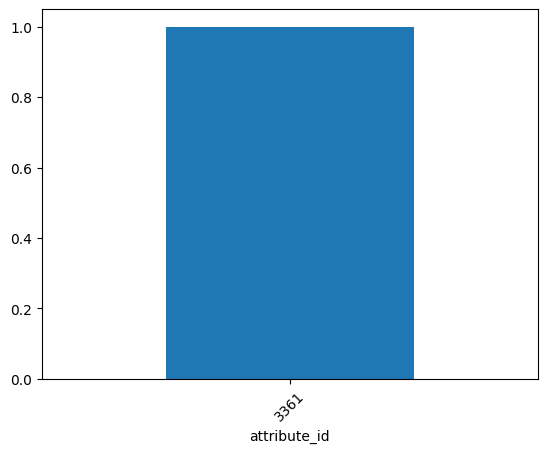

In [14]:
# Grouping by Attribute value
value_count = df['attribute_id'].value_counts()
print(value_count)
value_count.plot(kind='bar', rot=45)

date_sighting
0    1
Name: count, dtype: int64


<Axes: xlabel='date_sighting'>

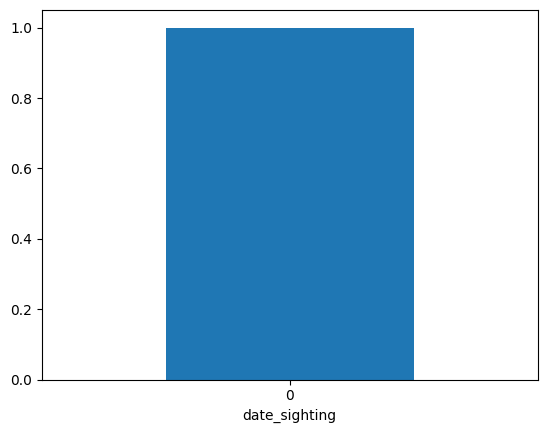

In [15]:
# Grouping by weekday (0-indexed)
amount_per_weekday = df['date_sighting'].dt.weekday.value_counts()
print(amount_per_weekday)
amount_per_weekday.plot(kind='bar', rot=0)

date_sighting
3    1
Name: one, dtype: int64


<Axes: xlabel='date_sighting'>

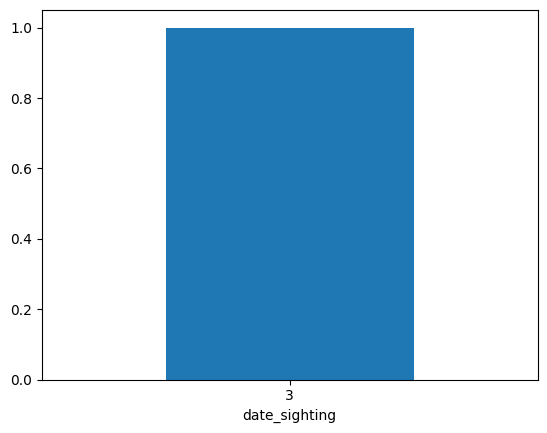

In [16]:
amount_per_weekday_for_each_attribute = df.groupby([df['date_sighting'].dt.hour])['one'].sum()
print(amount_per_weekday_for_each_attribute)
amount_per_weekday_for_each_attribute.plot(kind='bar', rot=0)